### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading dataset

For this example we will use a small **rooftop** dataset in addition to the dataset supplied by **https://www.airs-dataset.com/**. It is a set of:
 - **train** images + segmentation masks (small dataset/ very similar to validation set)
 - **cc_train** Images + segmentation masks (large dataset / quite different from rest of data)
 - **validation** images + segmentation masks

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
DATA_DIR = 'images/'
CHRISTCHURCH_DIR = 'trainval'

x_train_dir = os.path.join(DATA_DIR, 'frames/train')
y_train_dir = os.path.join(DATA_DIR, 'masks/train')

x_cc_train_dir = os.path.join(CHRISTCHURCH_DIR, 'train/image')
y_cc_train_dir = os.path.join(CHRISTCHURCH_DIR, 'train/label')

x_valid_dir = os.path.join(DATA_DIR, 'validation/frames')
y_valid_dir = os.path.join(DATA_DIR, 'validation/masks')

# Dataloader and utility functions 

In [44]:
from util import *
from data import *

In [5]:
#image = cv2.imread(self.images_fps[i])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('/nfs/OPTI/bzfander/rooftop_challenge/trainval/train/label/christchurch_11.tif', 0)

In [46]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['rooftop'])

dataset_cc = Dataset(x_cc_train_dir, y_cc_train_dir, classes=['rooftop'])


image, mask = dataset[6] # get some sample
visualize(
    image=image, 
    rooftop_mask=mask[..., 0].squeeze(),
    #rooftop_mask=mask[..., 1].squeeze(),
    #background_mask=mask[..., 2].squeeze(),
)

TypeError: __init__() got an unexpected keyword argument 'mask_treshhold'

In [43]:
from augmentation import *

In [45]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir,
                  classes=['rooftop'],
                  augmentation=get_training_augmentation())
dataset_cc = Dataset(x_cc_train_dir, y_cc_train_dir,
                     augmentation=get_cc_training_augmentation(),
                     mask_treshhold=1)
data = dataset
i = 1
print('path image:', data.images_fps[i])
image, mask = data[i] # get some sample
visualize(
    image=image, 
    rooftop_mask=mask[..., 0].squeeze(),
)

TypeError: __init__() got an unexpected keyword argument 'mask_treshhold'

# Segmentation model training

In [14]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [15]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['rooftop']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [16]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [17]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
total_loss = sm.losses.BinaryFocalLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [23]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


path image: images/validation/frames/551.png


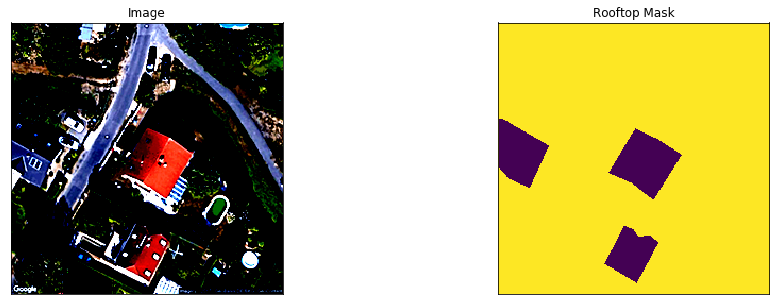

(1, 256, 256, 3)

In [26]:
# Dataset for validataion on dida data
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=['rooftop'],
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

i = 4
print('path image:', valid_dataset.images_fps[i])
image, mask = valid_dataset[i] # get some sample
visualize(
    image=image, 
    rooftop_mask=mask[..., 0].squeeze(),
)
valid_dataloader[0][0].shape

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=12, #len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [40]:
# load best weights
model.load_weights('best_model.h5') 

In [41]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 11.897
mean iou_score: 0.0091129
mean f1-score: 0.01804


# Visualization of results on test dataset

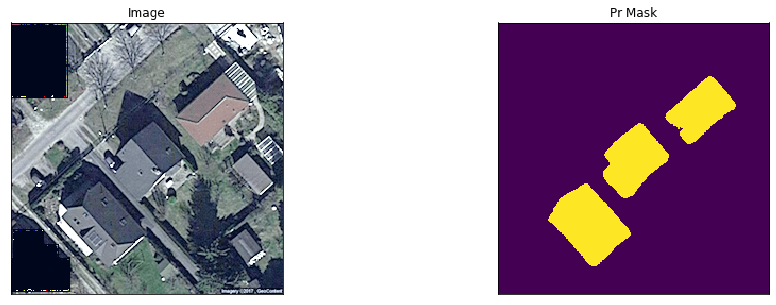

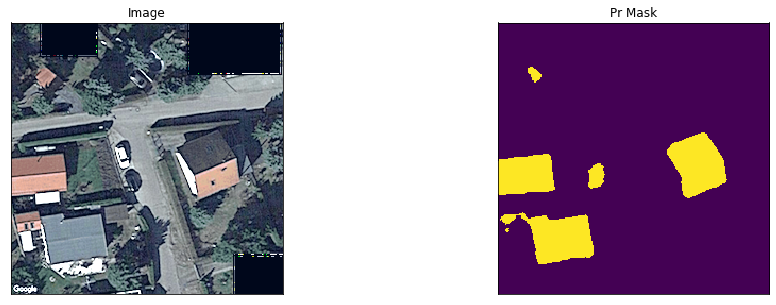

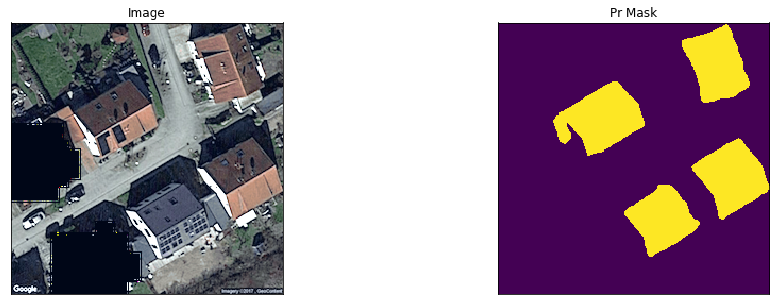

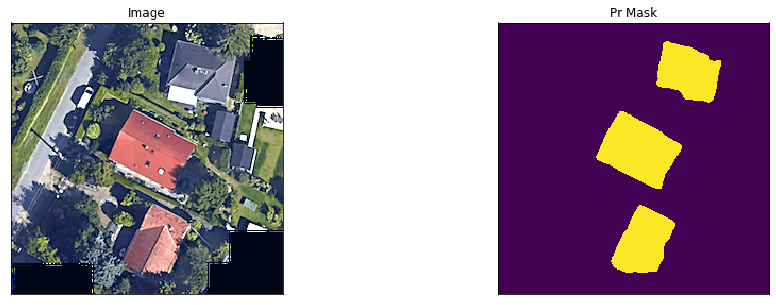

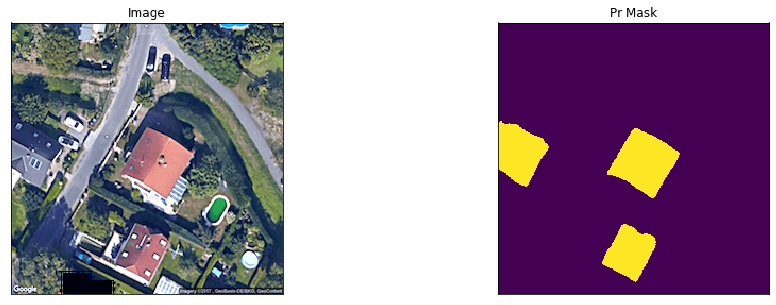

In [42]:
out_path='images/results'
for i in range(5):
    
    image, gt_mask = valid_dataset[i]
    image_name = valid_dataset.ids[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    # plt.imsave(f'{out_path}/{image_name}', pr_mask[..., 0].squeeze())
    visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    

In [29]:
from util import save_predictions
save_predictions(valid_dataset, model)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (256, 256, 3)